In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

Using TensorFlow backend.
/home/ucdavislawrence/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ucdavislawrence/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ucdavislawrence/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ucdavislawrence/.local/lib/pytho

In [10]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [11]:
df2 = pd.read_csv("fundamentals.csv")
df2.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [12]:
symbols = list(set(df.symbol)) #reading symbols
len(symbols)

501

In [13]:
symbols[500]

'ENDP'

In [14]:
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,312.304948,310.955001,313.580158,3927000.0,312.205308
2010-01-05,312.419511,309.610028,312.748278,6031900.0,310.830459
2010-01-06,311.761979,302.048370,311.761979,7987100.0,302.994813
2010-01-07,303.562685,295.218951,303.861575,12876600.0,295.941242
2010-01-08,294.895159,293.455551,300.499172,9483900.0,299.886470


In [15]:
df.describe()

,open,low,high,volume,adj close
count,1762.000000,1762.000000,1762.000000,1.762000e+03,1762.000000
mean,459.806530,455.659218,463.484281,4.051179e+06,459.617409
std,174.026396,172.601608,175.232816,2.933261e+06,173.946191
min,218.336998,216.005726,220.314587,7.900000e+03,217.221182
25%,298.255074,295.896412,300.824200,1.901175e+06,298.389573
50%,436.554429,434.103619,438.701390,3.642400e+06,436.711351
75%,578.422067,572.884750,581.870130,5.165425e+06,577.497020
max,816.679993,805.140015,816.679993,2.976060e+07,813.109985


In [16]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.157047,0.161167,0.156390,0.131722,0.159399
2010-01-05,0.157238,0.158884,0.154995,0.202469,0.157092
2010-01-06,0.156140,0.146049,0.153341,0.268184,0.143942
2010-01-07,0.142436,0.134457,0.140094,0.432522,0.132105
2010-01-08,0.127950,0.131464,0.134455,0.318492,0.138726


In [17]:
l=df.values
len(l)

1762

In [19]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.values
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [20]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [21]:
window = 22
X_train, y_train, X_test, y_test = load_data(df, window)
#print (X_train[0], y_train[0])

In [22]:
X_test.shape

(174, 22, 5)

In [23]:
model = build_model([5,window,1])

Compilation Time :  0.039656639099121094


In [24]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)


Train on 1408 samples, validate on 157 samples
Epoch 1/90
1408/1408 [==============================] - 3s 2ms/step - loss: 0.1327 - accuracy: 7.1023e-04 - val_loss: 0.6053 - val_accuracy: 0.0000e+00
Epoch 2/90
1408/1408 [==============================] - 2s 2ms/step - loss: 0.0955 - accuracy: 7.1023e-04 - val_loss: 0.2435 - val_accuracy: 0.0000e+00
Epoch 3/90
1408/1408 [==============================] - 2s 1ms/step - loss: 0.0314 - accuracy: 7.1023e-04 - val_loss: 0.0900 - val_accuracy: 0.0000e+00
Epoch 4/90
1408/1408 [==============================] - 2s 2ms/step - loss: 0.0226 - accuracy: 7.1023e-04 - val_loss: 0.1948 - val_accuracy: 0.0000e+00
Epoch 5/90
1408/1408 [==============================] - 2s 2ms/step - loss: 0.0193 - accuracy: 7.1023e-04 - val_loss: 0.1323 - val_accuracy: 0.0000e+00
Epoch 6/90
1408/1408 [==============================] - 2s 2ms/step - loss: 0.0064 - accuracy: 7.1023e-04 - val_loss: 0.0364 - val_accuracy: 0.0000e+00
Epoch 7/90
1408/1408 [==================

Epoch 53/90
1408/1408 [==============================] - 2s 1ms/step - loss: 0.0010 - accuracy: 7.1023e-04 - val_loss: 0.0091 - val_accuracy: 0.0000e+00
Epoch 54/90
1408/1408 [==============================] - 2s 1ms/step - loss: 0.0010 - accuracy: 7.1023e-04 - val_loss: 0.0085 - val_accuracy: 0.0000e+00
Epoch 55/90
1408/1408 [==============================] - 2s 1ms/step - loss: 0.0011 - accuracy: 7.1023e-04 - val_loss: 0.0094 - val_accuracy: 0.0000e+00
Epoch 56/90
1408/1408 [==============================] - 2s 1ms/step - loss: 9.9831e-04 - accuracy: 7.1023e-04 - val_loss: 0.0090 - val_accuracy: 0.0000e+00
Epoch 57/90
1408/1408 [==============================] - 2s 1ms/step - loss: 9.7864e-04 - accuracy: 7.1023e-04 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 58/90
1408/1408 [==============================] - 2s 1ms/step - loss: 0.0010 - accuracy: 7.1023e-04 - val_loss: 0.0102 - val_accuracy: 0.0000e+00
Epoch 59/90
1408/1408 [==============================] - 2s 1ms/step - los

In [25]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(174, 1)


In [26]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)

# Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [27]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00113 MSE (0.03 RMSE)
Test Score: 0.01039 MSE (0.10 RMSE)


(0.0011325655362982385, 0.010390266219432327)

In [28]:
newp

array([[696.2118 ],
       [694.6464 ],
       [692.34845],
       [689.16974],
       [685.54663],
       [681.47375],
       [677.4699 ],
       [673.5529 ],
       [669.9204 ],
       [666.8806 ],
       [664.7472 ],
       [663.73517],
       [663.8337 ],
       [664.65485],
       [665.83575],
       [667.2511 ],
       [668.7898 ],
       [670.2519 ],
       [671.3323 ],
       [671.8692 ],
       [672.25696],
       [672.4567 ],
       [672.6097 ],
       [673.2365 ],
       [674.05774],
       [675.14734],
       [676.63464],
       [678.23224],
       [679.7094 ],
       [680.8307 ],
       [681.4588 ],
       [681.73804],
       [682.06506],
       [682.3608 ],
       [682.3212 ],
       [682.0174 ],
       [681.44604],
       [680.81946],
       [679.7692 ],
       [677.9698 ],
       [675.8129 ],
       [673.54736],
       [671.3849 ],
       [669.31335],
       [666.5408 ],
       [663.28827],
       [660.3587 ],
       [657.99945],
       [656.3437 ],
       [655.5876 ],


In [29]:
newy_test

array([[723.150024],
       [708.140015],
       [705.840027],
       [691.02002 ],
       [693.01001 ],
       [698.210022],
       [692.359985],
       [695.700012],
       [701.429993],
       [711.119995],
       [712.900024],
       [723.179993],
       [715.289978],
       [713.309998],
       [710.830017],
       [716.48999 ],
       [706.22998 ],
       [706.630005],
       [700.320007],
       [709.73999 ],
       [704.23999 ],
       [720.090027],
       [725.27002 ],
       [724.119995],
       [732.659973],
       [735.719971],
       [734.150024],
       [730.400024],
       [722.340027],
       [716.549988],
       [716.650024],
       [728.280029],
       [728.580017],
       [719.409973],
       [718.359985],
       [718.27002 ],
       [718.919983],
       [710.359985],
       [691.719971],
       [693.710022],
       [695.940002],
       [697.460022],
       [701.869995],
       [675.219971],
       [668.26001 ],
       [680.039978],
       [684.109985],
       [692.0

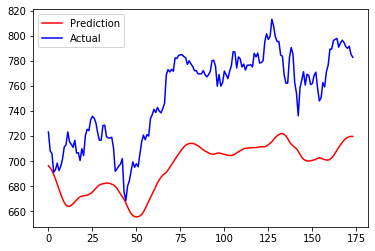

In [30]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()